<a href="https://colab.research.google.com/github/Anuj-1996/Indian-Market-Volatility/blob/main/Nifty_Volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 4.0 MB/s 


In [13]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import yfinance as yf
from arch.__future__ import reindexing
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

In [14]:
# Defining the Ticker
ticker = yf.Ticker('^NSEI')

# Obtaining Historical Market Data
start_date = '2007-10-01'
end_date = '2022-09-16'
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
N50 = ticker.history(start=start_date, end=end_date,sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
N50.reset_index(inplace=True)
N50.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2007-10-01,5021.500000,5089.299805,5001.350098,5068.950195,0,0,0
1,2007-10-03,5069.000000,5261.350098,5034.149902,5210.799805,0,0,0
2,2007-10-04,5211.649902,5233.100098,5126.049805,5208.649902,0,0,0
3,2007-10-05,5208.149902,5248.549805,5164.500000,5185.850098,0,0,0
4,2007-10-08,5186.250000,5249.299805,5024.750000,5085.100098,0,0,0


Removing unwanted columns

In [15]:
N50.drop(N50.columns[[5,6,7]], axis=1, inplace=True)
N50.set_index('Date', inplace= True)
N50.tail()

,Open,High,Low,Close
Date,,,,
2022-09-09,17923.349609,17925.949219,17786.000000,17833.349609
2022-09-12,17890.849609,17980.550781,17889.150391,17936.349609
2022-09-13,18044.449219,18088.300781,18015.449219,18070.050781
2022-09-14,17771.150391,18091.550781,17771.150391,18003.750000
2022-09-15,18046.349609,18096.150391,17861.500000,17877.400391


Daily Sampling for seasonal decompose

In [17]:
N50_daily= N50.resample('D')
N50_mean = N50_daily.mean()
N50_mean.tail()

,Open,High,Low,Close
Date,,,,
2022-09-11,NaN,NaN,NaN,NaN
2022-09-12,17890.849609,17980.550781,17889.150391,17936.349609
2022-09-13,18044.449219,18088.300781,18015.449219,18070.050781
2022-09-14,17771.150391,18091.550781,17771.150391,18003.750000
2022-09-15,18046.349609,18096.150391,17861.500000,17877.400391


In [18]:
# Forward fill the data
N50_day = N50.resample('D').ffill()
N50_day.tail()

,Open,High,Low,Close
Date,,,,
2022-09-11,17923.349609,17925.949219,17786.000000,17833.349609
2022-09-12,17890.849609,17980.550781,17889.150391,17936.349609
2022-09-13,18044.449219,18088.300781,18015.449219,18070.050781
2022-09-14,17771.150391,18091.550781,17771.150391,18003.750000
2022-09-15,18046.349609,18096.150391,17861.500000,17877.400391


In [19]:
# Check for null rows
N50_day.isnull().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

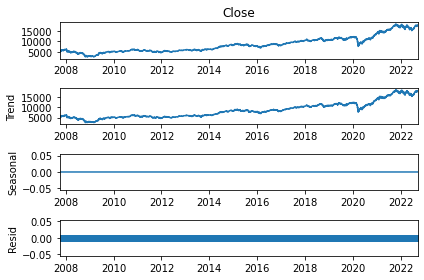

In [20]:
daily = seasonal_decompose(N50_day['Close'], model = 'additive', period= 1)
daily.plot()
pyplot.show()

Text(0.5, 1.0, 'N50 Returns')

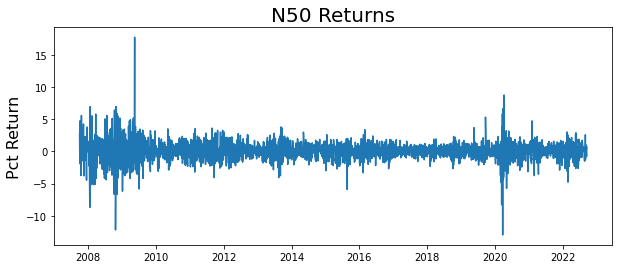

In [21]:
returns = 100 * N50.Close.pct_change().dropna()
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('N50 Returns', fontsize=20)

### **PACF**

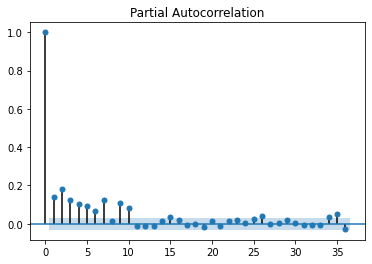

In [24]:
plot_pacf(returns**2)
plt.show()

## **GARCH 1,1**

In [29]:
#use p and q value as 1,1. you may change p and q, however, as per my experiance choose p and q value to get P>|t| >= 0.05 in GARCH Model Results 
model = arch_model(returns, p=1, q=1)
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6156025235.126965
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2009871865.0391018
Iteration:      3,   Func. Count:     22,   Neg. LLF: 5614.503950741851
Iteration:      4,   Func. Count:     28,   Neg. LLF: 5646.246501276503
Iteration:      5,   Func. Count:     34,   Neg. LLF: 5765.381850863392
Iteration:      6,   Func. Count:     41,   Neg. LLF: 5579.893282472742
Iteration:      7,   Func. Count:     46,   Neg. LLF: 5597.380653483784
Iteration:      8,   Func. Count:     52,   Neg. LLF: 5590.193684096124
Iteration:      9,   Func. Count:     58,   Neg. LLF: 5577.427984828296
Iteration:     10,   Func. Count:     63,   Neg. LLF: 5577.420693362686
Iteration:     11,   Func. Count:     68,   Neg. LLF: 5577.420633094374
Iteration:     12,   Func. Count:     72,   Neg. LLF: 5577.420633098827
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5577.420633094374
            Iterations: 12


In [30]:
print(model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5577.42
Distribution:                  Normal   AIC:                           11162.8
Method:            Maximum Likelihood   BIC:                           11187.7
                                        No. Observations:                 3663
Date:                Thu, Sep 15 2022   Df Residuals:                     3662
Time:                        15:19:37   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0793  1.637e-02      4.845  1.268e-06 [4.723e-0

In [31]:
rolling_predictions = []
test_size = 120

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex=True)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [32]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-120:])

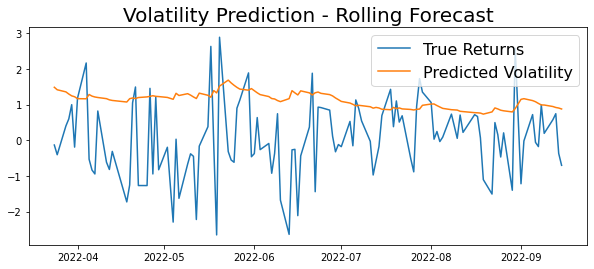

In [33]:
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-120:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

## **NXT 7 DAYS**

In [34]:
train = returns
model = arch_model(train, p=1, q=1)
model_fit = model.fit(disp='off')

In [35]:
pred = model_fit.forecast(horizon=7, reindex=True)
future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

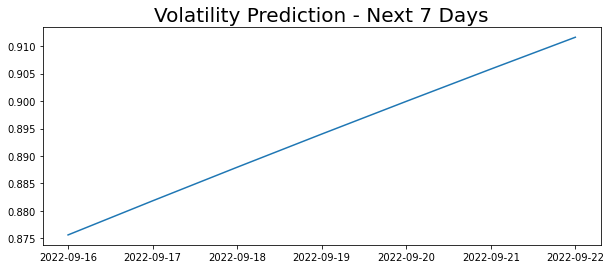

In [36]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)